# 📓 Notebook 01: Exploratory Data Analysis

## Short description of the notebook

# NOTES
What we have done:

- Preliminary data inspection

- Add missing data to LLL1
  - Several classic methods tried with low accuracy
  - Imputation with Iterative imputer is good
  - Cannot find anything like LLL1 to extract the real missing data

- Save clean dataset

- Plots
  - timeseries
  - ACF, PACF
  - Correlation matrix
  - Rolling volatility
  - ...

# 📚 Dependencies

In [1]:
# Standard library
import os
import sys
import warnings
import random
import logging
import pickle
from pathlib import Path
import re

# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Others
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from typing import List, Optional, Union
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# 🌐 General Setup

In [2]:
%%bash
cd /content

REPO=https://github.com/jacopo-raffaeli/portfolio-replica.git
DIR=portfolio-replica

# Clone if needed, else pull latest
if [ ! -d "$DIR" ]; then
  git clone $REPO > /dev/null 2>&1
else
  cd $DIR
  git pull origin main > /dev/null 2>&1
  cd ..
fi

# Enter project root and install dependencies
cd $DIR
pip install -r requirements.txt > /dev/null 2>&1


In [3]:
# Add repo root to sys.path for imports
PROJECT_ROOT = "/content/portfolio-replica"
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    sys.path.append(os.path.join(PROJECT_ROOT, 'src'))

# Set working directory for relative paths
os.chdir(PROJECT_ROOT)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/portfolio-replica


In [4]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Pandas display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.precision', 3)

# Seaborn and Matplotlib display options
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Set reproducible seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)

# Define paths
data_raw_path = "data/raw/"
data_interim_path = "data/interim/"
data_processed_path = "data/processed/"

# 🛠 Utilities

## Plots

In [ ]:
def plot_series(
    df: pd.DataFrame,
    cols: list,
    title: str = None,
    save_path: str = None,
    dpi: int = 300,
    transparent: bool = True
):
    """Plot one or more time series."""
    plt.figure()
    ax = df[cols].plot()
    ax.set_title(title or f"Time Series: {', '.join(cols)}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.legend()
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=dpi, transparent=transparent)

def plot_acf_pacf(
    series: pd.Series,
    lags: int,
    title_prefix: str = None,
    save_path: str = None,
    dpi: int = 300,
    transparent: bool = True
):
    """Plot ACF and PACF of a series."""
    fig, axes = plt.subplots(2, 1)
    plot_acf(series.dropna(), lags=lags, ax=axes[0])
    plot_pacf(series.dropna(), lags=lags, ax=axes[1])
    axes[0].set_title((title_prefix or "") + " ACF")
    axes[1].set_title((title_prefix or "") + " PACF")
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=dpi, transparent=transparent)

def plot_rolling_stats(
    series: pd.Series,
    window: int = 20,
    zscore: bool = False,
    title: str = None,
    save_path: str = None,
    dpi: int = 300,
    transparent: bool = True
):
    """Plot rolling mean & std or z-score."""
    rolling_mean = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()

    plt.figure()
    ax = plt.gca()
    if zscore:
        z = (series - rolling_mean) / rolling_std
        z.plot(ax=ax)
        ax.axhline(0, linestyle="--")
        ax.axhline(1, linestyle="--")
        ax.axhline(-1, linestyle="--")
        ax.set_title(title or f"Rolling Z-Score (window={window})")
    else:
        series.plot(ax=ax, alpha=0.5, label="Original")
        rolling_mean.plot(ax=ax, label=f"Mean ({window})")
        rolling_std.plot(ax=ax, label=f"Std ({window})")
        ax.set_title(title or f"Rolling Mean & Std (window={window})")
        ax.legend()
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=dpi, transparent=transparent)

def plot_correlation_matrix(
    df: pd.DataFrame,
    method: str = "pearson",
    title: str = None,
    save_path: str = None,
    dpi: int = 300,
    transparent: bool = True
):
    """Plot correlation heatmap."""
    corr = df.corr(method=method)
    plt.figure()
    ax = sns.heatmap(corr, annot=True, fmt=".2f", square=True)
    ax.set_title(title or f"{method.title()} Correlation Matrix")
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=dpi, transparent=transparent)

def plot_and_save(
    plot_func,
    *args,
    plot_type: str,
    subject: str,
    variant: str = "",
    directory: str = "reports/figures",
    extension: str = "png",
    dpi: int = 300,
    transparent: bool = True,
    show: bool = True,
    **kwargs
):
    """Wrapper to standardize plot saving and naming."""
    Path(directory).mkdir(parents=True, exist_ok=True)
    subject_clean = sanitize_filename(subject)
    variant_clean = sanitize_filename(variant) if variant else ""
    filename_parts = [plot_type, subject_clean]
    if variant_clean:
        filename_parts.append(variant_clean)
    filename = "__".join(filename_parts) + f".{extension}"
    save_path = Path(directory) / filename

    plot_func(*args, save_path=str(save_path), dpi=dpi, transparent=transparent, **kwargs)
    if show:
        plt.show()
    else:
        plt.close()

def sanitize_filename(s: str) -> str:
    """Sanitize strings for filenames (e.g. column names)."""
    return re.sub(r"[^a-zA-Z0-9_]", "_", s.strip().replace(" ", "_"))

## LLL1 Missing data

In [ ]:
def impute_series_with_lag(
    df: pd.DataFrame,
    target_col: str,
    corruption_start_idx: int,
    min_corr: float = 0.2,
    max_features: int = 3,
    lag: int = 1,
    random_state: Optional[int] = 42,
    round_digits: Optional[int] = 1
) -> pd.Series:

    """
    Impute missing values in a time series using IterativeImputer with lagged features.

    Parameters
    ----------
    df : pd.DataFrame
        Full input DataFrame including the target column.
    target_col : str
        Name of the target column to impute (e.g., "LLL1 Comdty").
    corruption_start_idx : int
        Index (positional) at which to start treating target_col as missing.
    min_corr : float, optional
        Minimum absolute correlation for a feature to be included.
    max_features : int, optional
        Maximum number of top correlated features to use.
    lag : int, optional
        Lag for lagged features.
    random_state : int, optional
        Random seed for reproducibility.
    round_digits : int or None, optional
        If not None, round imputed values to this number of decimal digits.

    Returns
    -------
    pd.Series
        Imputed time series (same length as input).
    """

    df_copy = df.copy()
    target_series = df_copy[target_col].copy()
    target_series.iloc[corruption_start_idx:] = np.nan

    df_lagged = df_copy.copy()
    df_lagged["__target_fixed__"] = target_series

    # Correlation-based feature selection
    corr_matrix = df_lagged.iloc[:corruption_start_idx].corr()
    correlations = corr_matrix["__target_fixed__"].drop("__target_fixed__").dropna()
    top_features = correlations[correlations.abs() > min_corr]
    selected_features = top_features.head(max_features).index.tolist()

    # Add lagged features
    lagged_cols = []
    for col in selected_features + ["__target_fixed__"]:
        lagged_col = f"{col}_lag"
        df_lagged[lagged_col] = df_lagged[col].shift(lag)
        lagged_cols.append(lagged_col)

    imputation_data = df_lagged[lagged_cols].copy()

    imp = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=random_state)
    imputed_array = imp.fit_transform(imputation_data)

    target_lagged_col = f"__target_fixed___lag"
    imputed_target_lagged = imputed_array[:, lagged_cols.index(target_lagged_col)]

    # Shift back to get original timing
    imputed_target = pd.Series(imputed_target_lagged, index=df.index).shift(-lag)
    imputed_target.iloc[:lag] = target_series.iloc[:lag]  # preserve initial values

    if round_digits is not None:
        imputed_target = np.round(imputed_target, round_digits)

    return pd.Series(imputed_target, index=df.index, name=f"{target_col}_imputed")


# 💾 Load Dataset

In [5]:
# Read full names (row 4)
full_names_df = pd.read_excel(data_raw_path + "dataset_raw.xlsx", header=None, skiprows=3, nrows=1)
full_names = full_names_df.iloc[0].tolist()[1:]

# Read Bloomberg tickers (row 5)
tickers_df = pd.read_excel(data_raw_path + "dataset_raw.xlsx", header=None, skiprows=4, nrows=1)
tickers = tickers_df.iloc[0].tolist()[1:]

# Create and save a dictionary mapping tickers to full names
tickers_name_dict = dict(zip(tickers, full_names))
with open(data_processed_path + "tickers_name_dict.pkl", "wb") as f:
    pickle.dump(tickers_name_dict, f)

# Read the actual data without using any row as a header (from row 6)
df_raw = pd.read_excel(data_raw_path + "dataset_raw.xlsx", header=None, skiprows=5)

# Set column names and index
df_raw.columns = ['Date'] + tickers
df_raw['Date'] = pd.to_datetime(df_raw['Date'], format='%d/%m/%Y')
df_raw = df_raw.set_index('Date')

In [6]:
# Target indices for the monster index
#indeces_columns = [
#    "MXWO",     # MSCI World
#    "MXWD",     # MSCI ACWI
#    "LEGATRUU", # Global Agg Bond
#    "HFRXGL"    # Hedge Fund Index
#]

# Save the indeces dataset
#df_raw[indeces_columns].to_parquet(data_processed_path + "indices.parquet")

# 🔍 Inspect Dataset

## Preliminary Inspection

In [ ]:
print("Dataset shape:", df_raw.shape)
print(f"From {df_raw.index.min()} to {df_raw.index.max()}, total days: {df_raw.shape[0]}")
display(df_raw.index.to_series().diff().value_counts().head())
display(df_raw.head())

Dataset shape: (705, 15)
From 2007-10-23 00:00:00 to 2021-04-20 00:00:00, total days: 705


,count
Date,
7 days,704


,MXWO,MXWD,LEGATRUU,HFRXGL,RX1,TY1,GC1,CO1,ES1,VG1,NQ1,LLL1,TP1,DU1,TU2
Date,,,,,,,,,,,,,,,
2007-10-23,1633.44,414.14,350.214,1343.63,113.70,110.516,759.0,82.85,1525.50,4393.0,2212.00,1287.0,1570.5,103.385,103.719
2007-10-30,1663.89,423.26,352.541,1356.53,113.79,110.656,787.8,87.44,1536.00,4476.0,2217.75,1323.9,1610.5,103.410,103.812
2007-11-06,1651.59,419.51,354.176,1360.20,113.79,110.875,823.4,93.26,1525.00,4425.0,2233.50,1320.0,1575.5,103.410,104.047
2007-11-13,1601.81,405.98,357.222,1347.16,114.35,111.719,799.0,88.83,1483.25,4323.0,2066.75,1271.0,1440.5,103.595,104.305
2007-11-20,1570.74,398.54,359.445,1335.21,114.72,113.156,791.4,95.49,1446.00,4296.0,2035.50,1225.2,1472.5,103.800,104.945


In [ ]:
print("Dataset Statistics:")
display(df_raw.describe())

In [ ]:
print("Missing Values:")
display(df_raw.isna().sum().sort_values(ascending=False))

In [ ]:
df_raw.iloc[:,-5:].plot(subplots=True, figsize=(14, 8), title="First few time series")

## Add missing data to LLL1

### Search for real missing data

In [ ]:
!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git --quiet
from tvDatafeed import TvDatafeed,Interval

In [ ]:
tv = TvDatafeed()

# Get 1000 weekly bars (~20 years)
df_LLL1 = tv.get_hist(
    symbol="LLL1",
    exchange="NYMEX",
    interval=Interval.in_weekly,
    n_bars=1000
)

### Infer missing data

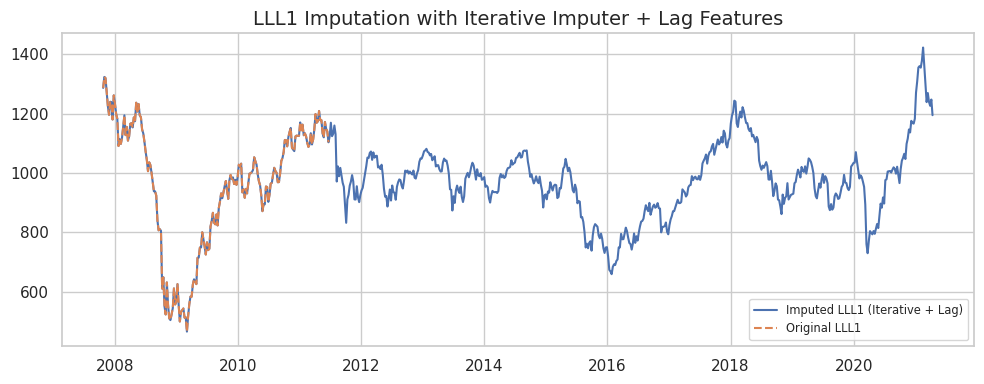

In [ ]:
# Infer missing data for LLL1 using IterativeImputer with lagged features.
LLL1_imputed_series = impute_series_with_lag(
    df=df_raw,
    target_col="LLL1",
    corruption_start_idx=192,
    lag = 1
)

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(df_raw.index, LLL1_imputed_series, label="Imputed LLL1 (Iterative + Lag)")
plt.plot(df_raw.index[:192], df_raw["LLL1"].iloc[:192], label="Original LLL1", linestyle="--")
plt.title("LLL1 Imputation with Iterative Imputer + Lag Features")
plt.legend(fontsize='x-small')
plt.tight_layout()
plt.show()

# Replace the corrupted column in the df and save
df_cleaned = df_raw.copy()
df_cleaned["LLL1"] = LLL1_imputed_series
df_cleaned.to_parquet("data/processed/df_cleaned_imp_LLL1.parquet", index=True)


## Save Futures Dataset

In [ ]:
# Load the cleaned df
LLL1_version = "imp"
df_cleaned_filename = f"df_cleaned_{LLL1_version}_LLL1.parquet"
df_cleaned = pd.read_parquet(data_processed_path + df_cleaned_filename)

# Target indices for the monster index
indeces_columns = [
    "MXWO",     # MSCI World
    "MXWD",     # MSCI ACWI
    "LEGATRUU", # Global Agg Bond
    "HFRXGL"    # Hedge Fund Index
]

# Remaining columns go to futures
futures_columns = [col for col in df_cleaned.columns if col not in indeces_columns]

# Save
df_cleaned[futures_columns].to_parquet(data_processed_path + f"futures_cleaned_{LLL1_version}_LLL1.parquet")

# 📈 Plots

In [ ]:
# Load the cleaned df
df_cleaned_filename = "df_cleaned_imp_LLL1.parquet"
df_cleaned = pd.read_parquet(data_processed_path + df_cleaned_filename)

In [ ]:
for col in df_cleaned.columns:
  plot_series(df_cleaned, cols=col, title=col + " Over Time")
  plot_acf_pacf(df_cleaned[col], lags=20, title_prefix=col)
  plot_rolling_stats(df_cleaned[col], window=20, title=col + " Rolling Stats")
plot_correlation_matrix(df_cleaned, title="Correlation Matrix")

# PUSH

In [ ]:
!git config --global user.email "jacoporaffaeli@gmail.com"
!git config --global user.name "jacopo-raffaeli"

In [ ]:
from getpass import getpass
import os

# 1. Get your GitHub Personal Access Token securely
token = getpass("Paste your GitHub Personal Access Token: ")
os.environ['GITHUB_TOKEN'] = token

# 2. Set your GitHub repo details
GITHUB_USERNAME = "jacopo-raffaeli"
REPO_NAME = "portfolio-replica"
BRANCH = "main"

# 3. Construct remote URL with token embedded (hidden from output)
remote_url = f"https://{token}@github.com/{GITHUB_USERNAME}/{REPO_NAME}.git"

# 4. Set git user info (if not done already)
!git config --global user.email "jacoporaffaeli@gmail.com"
!git config --global user.name "jacopo-raffaeli"

# 5. Change remote origin URL to token-embedded one
!git remote set-url origin {remote_url}


Paste your GitHub Personal Access Token: ··········


In [ ]:
# 6. Add and commit changes (customize your commit message)
!git add .
!git commit -m "feat: Add Initial EDA" || echo "No changes to commit."

# 7. Push to GitHub
!git push origin {BRANCH}

[main af4dbbb] feat: Add Initial EDA
 3 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 data/processed/futures_cleaned_imp_LLL1.parquet
 create mode 100644 data/processed/indices.parquet
Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 2 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 21.55 KiB | 5.39 MiB/s, done.
Total 7 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 2 local objects.
To https://github.com/jacopo-raffaeli/portfolio-replica.git
   7c32e5e..af4dbbb  main -> main
